In [1]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Reading top anime data

In [2]:
# Files in the data directory
os.listdir('../data')

['top_anime.json', 'user_cleaned.csv', 'user_lst.json']

In [3]:
# This data was collected on Feb. 27, 2021
with open('../data/top_anime.json') as f:
    data = json.load(f)

In [4]:
# List of columns
columns = [
    'mal_id',
    'url',
    'image_url',
    'trailer_url',
    'title',
    'title_japanese',
    'type',
    'source',
    'episodes',
    'status',
    'rating',
    'score',
    'rank',
    'popularity',
    'members',
    'favorites',
    'synopsis',
    'premiered',
    'studios',
    'genres'
]

In [5]:
# Creating pd.DataFrame object with above columns
df = pd.DataFrame(columns=columns)

In [6]:
# Adding top anime data to df
for col in columns:
    if not col in ['studios', 'genres']:
        df[col] = [ele[col] for ele in data]
    else:
        df[col] = [','.join([ele['name'] for ele in anime[col]]) for anime in data]

In [7]:
df['genres']

0       Action,Military,Adventure,Comedy,Drama,Magic,F...
1       Action,Military,Mystery,Super Power,Drama,Fant...
2       Action,Drama,Fantasy,Military,Mystery,Shounen,...
3                                         Thriller,Sci-Fi
4       Action,Comedy,Historical,Parody,Samurai,Sci-Fi...
                              ...                        
9995                                 Drama,Romance,School
9996                          Comedy,Drama,Mystery,Police
9997                   Drama,Mystery,Psychological,Seinen
9998                                   Comedy,Horror,Kids
9999                                         Comedy,Magic
Name: genres, Length: 10000, dtype: object

In [8]:
# Cleaning data

# Only including anime
df = df.loc[df['type']=='TV']

# Drop dupplicates
df = df.drop_duplicates(subset='mal_id', keep='last')

# Drop anime without rating
df = df.loc[~df['score'].isnull()]

# Filling NaN in 'synopsis' column with blank string
df['synopsis'] = df['synopsis'].fillna('')

In [9]:
# Printing number of rows and columns
print(df.shape)

(3729, 20)


In [10]:
df.head()

,mal_id,url,image_url,trailer_url,title,title_japanese,type,source,episodes,status,rating,score,rank,popularity,members,favorites,synopsis,premiered,studios,genres
0,5114,https://myanimelist.net/anime/5114/Fullmetal_A...,https://cdn.myanimelist.net/images/anime/1223/...,https://www.youtube.com/embed/--IcmZkvL0Q?enab...,Fullmetal Alchemist: Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,Manga,64.0,Finished Airing,R - 17+ (violence & profanity),9.19,1,3,2263160,184950,"""In order for something to be obtained, someth...",Spring 2009,Bones,"Action,Military,Adventure,Comedy,Drama,Magic,F..."
1,40028,https://myanimelist.net/anime/40028/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1000/...,https://www.youtube.com/embed/SlNpRThS9t8?enab...,Shingeki no Kyojin: The Final Season,進撃の巨人 The Final Season,TV,Manga,16.0,Currently Airing,R - 17+ (violence & profanity),9.16,2,111,771436,47575,Gabi Braun and Falco Grice have been training ...,Winter 2021,MAPPA,"Action,Military,Mystery,Super Power,Drama,Fant..."
2,38524,https://myanimelist.net/anime/38524/Shingeki_n...,https://cdn.myanimelist.net/images/anime/1517/...,https://www.youtube.com/embed/hKHepjfj5Tw?enab...,Shingeki no Kyojin Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,Manga,10.0,Finished Airing,R - 17+ (violence & profanity),9.11,3,59,1108079,42194,Seeking to restore humanity's diminishing hope...,Spring 2019,Wit Studio,"Action,Drama,Fantasy,Military,Mystery,Shounen,..."
3,9253,https://myanimelist.net/anime/9253/Steins_Gate,https://cdn.myanimelist.net/images/anime/5/731...,https://www.youtube.com/embed/27OZc-ku6is?enab...,Steins;Gate,STEINS;GATE,TV,Visual novel,24.0,Finished Airing,PG-13 - Teens 13 or older,9.11,4,9,1793962,149993,The self-proclaimed mad scientist Rintarou Oka...,Spring 2011,White Fox,"Thriller,Sci-Fi"
4,28977,https://myanimelist.net/anime/28977/Gintama°,https://cdn.myanimelist.net/images/anime/3/720...,None,Gintama°,銀魂°,TV,Manga,51.0,Finished Airing,PG-13 - Teens 13 or older,9.10,5,331,408892,12009,"Gintoki, Shinpachi, and Kagura return as the f...",Spring 2015,Bandai Namco Pictures,"Action,Comedy,Historical,Parody,Samurai,Sci-Fi..."


# Content-based recommender

In [11]:
# Synopsis matrix using TfidfVectorizer
tf_synop = TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=10)
tf_synop_matrix = tf_synop.fit_transform(df['synopsis'])

In [12]:
# Genre matrix
genre_matrix = df['genres'].str.get_dummies(sep=',').to_numpy()

In [13]:
# Concatenating synopsis matrix, genre matrix, and score matrix
matrix = np.concatenate((tf_synop_matrix.toarray(), genre_matrix), axis=1)

In [14]:
# Cosine similarity matrix
cosine_sim_content = pd.DataFrame(cosine_similarity(matrix, matrix), index=df['title'], columns=df['title'])

In [15]:
# Adding cosine_sim column
anime = 'Shingeki no Kyojin Season 3 Part 2'
cosine_sim_content[anime].sort_values(ascending=False)[1:20]

title
Shingeki no Kyojin Season 2                           0.928812
Shingeki no Kyojin: The Final Season                  0.914079
Shingeki no Kyojin Season 3                           0.903368
Shingeki no Kyojin                                    0.902037
Katsute Kami Datta Kemono-tachi e                     0.725576
Kaze no Youjinbou                                     0.639826
Zetsuen no Tempest                                    0.626300
One Piece                                             0.625896
GetBackers                                            0.625000
Concrete Revolutio: Choujin Gensou - The Last Song    0.600351
Fullmetal Alchemist: Brotherhood                      0.593283
Fullmetal Alchemist                                   0.593070
Tsubasa Chronicle 2nd Season                          0.592590
Concrete Revolutio: Choujin Gensou                    0.592384
Hunter x Hunter                                       0.584950
Shin Mazinger Shougeki! Z-hen                    

# Collaborative recommender

In [16]:
# Reading user_cleaned.csv
user_df = pd.read_csv("../data/user_cleaned.csv")

In [17]:
# Only including anime
user_df = user_df.loc[user_df['type']=='TV']

In [18]:
# Dropping users who are collected more than once (users who are part of multiple clubs)
user_df = user_df.drop_duplicates(subset=['username', 'title'], keep='first')

In [19]:
# Viewing first 5 rows of user_df
user_df.head()

,username,mal_id,title,score,type
2,--hasuki_komai--,6682,11eyes,6,TV
4,--hasuki_komai--,38101,5-toubun no Hanayome,6,TV
5,--hasuki_komai--,25397,Absolute Duo,6,TV
6,--hasuki_komai--,11759,Accel World,6,TV
8,--hasuki_komai--,34881,Aho Girl,5,TV


In [20]:
# Creating a pivot table for collaborative recommender
pivot = user_df.pivot_table(values='score', index='title', columns='username')

In [21]:
# Dropping users without any anime reviews
pivot = pivot.dropna(axis=0, how='all')

In [22]:
# Filling NaN with 0s
pivot = pivot.fillna(0)

In [23]:
# Identifying animes from user_df that are in top_anime and
# identifying animes from user_df that are not in top_anime

include_anime = []
drop_anime = []
for title in user_df['title'].unique():
    if title in df['title'].unique():
        include_anime.append(title)
    else:
        drop_anime.append(title)

# Dropping animes that are not in top_anime
pivot = pivot.drop(drop_anime)

In [24]:
# Cosine similarity matrix
cosine_sim_collab = pd.DataFrame(cosine_similarity(pivot, pivot), index=pivot.index, columns=pivot.index)

In [25]:
cosine_sim_collab[anime].sort_values(ascending=False)[1:20]

title
Shingeki no Kyojin Season 3                                   0.902848
Shingeki no Kyojin Season 2                                   0.785268
Shingeki no Kyojin                                            0.628497
Yakusoku no Neverland                                         0.618638
Kimetsu no Yaiba                                              0.611241
One Punch Man 2nd Season                                      0.546410
One Punch Man                                                 0.532382
Seishun Buta Yarou wa Bunny Girl Senpai no Yume wo Minai      0.531824
Boku no Hero Academia 3rd Season                              0.525024
Re:Zero kara Hajimeru Isekai Seikatsu                         0.522889
Boku no Hero Academia 2nd Season                              0.511174
Mob Psycho 100 II                                             0.505778
Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen    0.503726
Tokyo Ghoul                                                   0.499381


# Hybrid recommender

In [26]:
collab_level = 0.9
weighted_df = pd.merge(left=cosine_sim_content[anime], right=cosine_sim_collab[anime], on='title')
weighted_df['weighted_sim'] = weighted_df.iloc[:, 0] * (1-collab_level) + weighted_df.iloc[:, 1] * collab_level
weighted_df

,Shingeki no Kyojin Season 3 Part 2_x,Shingeki no Kyojin Season 3 Part 2_y,weighted_sim
title,,,
Fullmetal Alchemist: Brotherhood,0.593283,0.405167,0.423978
Shingeki no Kyojin: The Final Season,0.914079,0.463781,0.508811
Shingeki no Kyojin Season 3 Part 2,1.000000,1.000000,1.000000
Steins;Gate,0.007780,0.454237,0.409591
Gintama°,0.253540,0.135190,0.147025
...,...,...,...
Netsuzou TRap,0.183151,0.080734,0.090976
Ginyuu Mokushiroku Meine Liebe,0.210330,0.001379,0.022274
Girls Bravo: First Season,0.250000,0.024967,0.047470


In [27]:
final_df = pd.merge(left=df, right=weighted_df['weighted_sim'], left_on='title', right_on=weighted_df['weighted_sim'].index)

In [28]:
final_df.sort_values(by='weighted_sim', ascending=False)[['title', 'score', 'weighted_sim']][1:21]

,title,score,weighted_sim
46,Shingeki no Kyojin Season 3,8.60,0.902900
90,Shingeki no Kyojin Season 2,8.45,0.799622
79,Shingeki no Kyojin,8.48,0.655851
38,Yakusoku no Neverland,8.65,0.583799
43,Kimetsu no Yaiba,8.62,0.580978
949,One Punch Man 2nd Season,7.41,0.518858
164,Boku no Hero Academia 3rd Season,8.25,0.516549
1,Shingeki no Kyojin: The Final Season,9.16,0.508811
56,One Punch Man,8.57,0.506440
138,Boku no Hero Academia 2nd Season,8.32,0.504334


# Exploratory Data Analysis

In [29]:
# Number of unique users
len(user_df['username'].unique())

24575

In [30]:
# Number of unique animes
len(df['title'].unique())

3729

In [31]:
# Number of user reviews
len(user_df)

3894501

In [32]:
# Descriptive statistics of anime episodes, scores, members, and favorites
df[['episodes', 'score', 'members', 'favorites']].describe()

,episodes,score,members,favorites
count,3697.000000,3729.000000,3.729000e+03,3729.000000
mean,30.871517,6.949158,1.223597e+05,1913.686779
std,73.838407,0.719542,2.420404e+05,8544.760364
min,3.000000,5.370000,3.270000e+02,0.000000
25%,12.000000,6.430000,4.903000e+03,12.000000
50%,13.000000,6.920000,2.869600e+04,92.000000
75%,26.000000,7.420000,1.273980e+05,649.000000
max,1818.000000,9.190000,2.617175e+06,184950.000000


In [33]:
# Descriptive statistics of user scores
user_df['score'].describe()

count    3.894501e+06
mean     5.083165e+00
std      3.839576e+00
min      0.000000e+00
25%      0.000000e+00
50%      7.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: score, dtype: float64

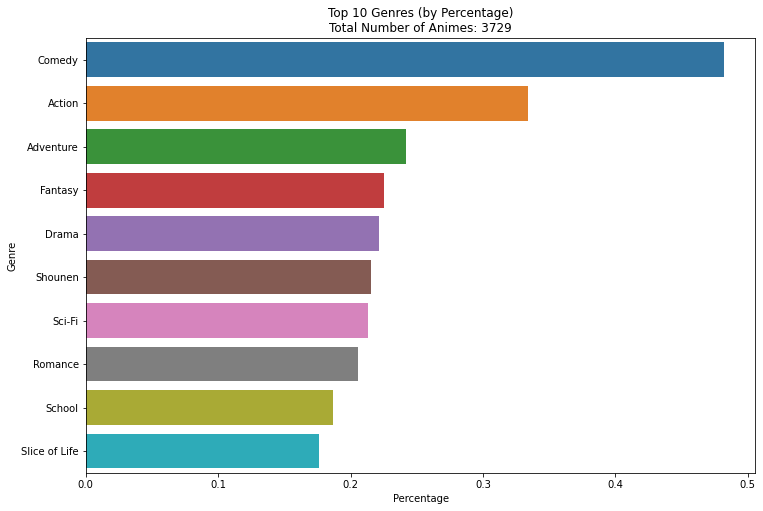

In [34]:
# Genre Percentages
genre_df = df['genres'].str.get_dummies(sep=',')
genre_percentages = genre_df.sum(axis=0)/len(genre_df)

plt.figure(figsize=(12,8))
plt.title(f'Top 10 Genres (by Percentage)\nTotal Number of Animes: {len(genre_df)}')
sns.barplot(
    y=genre_percentages.sort_values(ascending=False).index[:10],
    x=genre_percentages.sort_values(ascending=False)[:10]
    )
plt.ylabel('Genre')
plt.xlabel('Percentage');

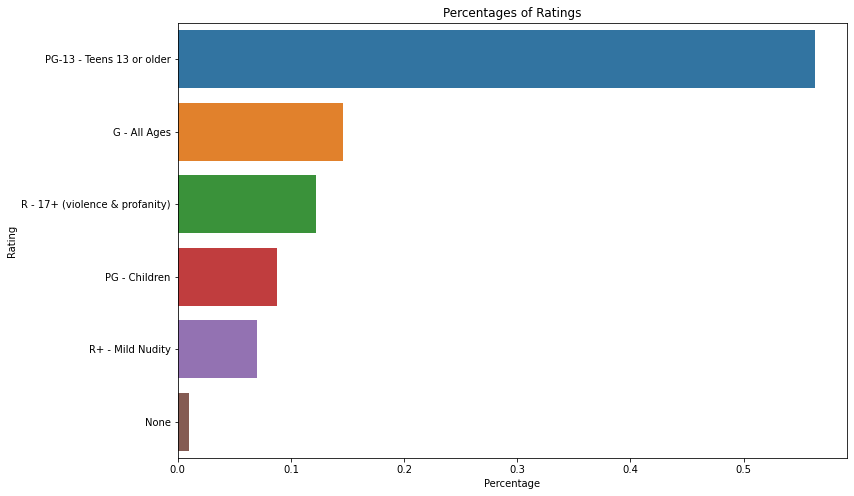

In [35]:
plt.figure(figsize=(12, 8))
plt.title('Percentages of Ratings')
sns.barplot(
    y=df['rating'].value_counts(normalize=True).index,
    x=df['rating'].value_counts(normalize=True)
)
plt.ylabel('Rating')
plt.xlabel('Percentage');

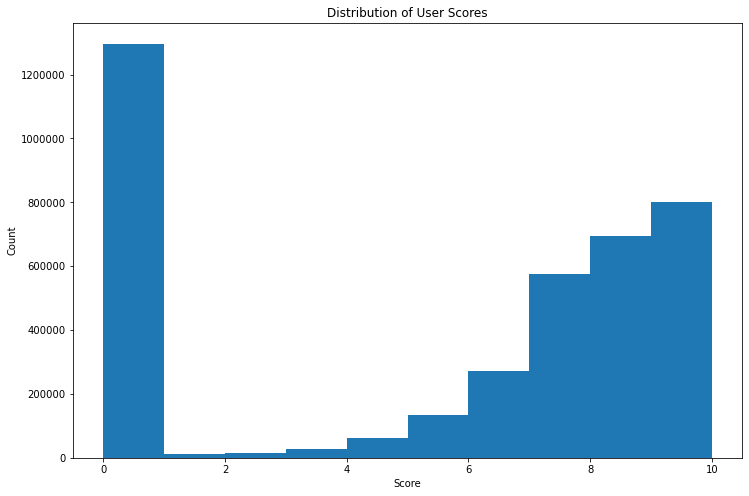

In [36]:
# Distribution of User Scores
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.ticklabel_format(style='plain')
plt.title('Distribution of User Scores')
plt.hist(user_df['score'])
plt.ylabel('Count')
plt.xlabel('Score');

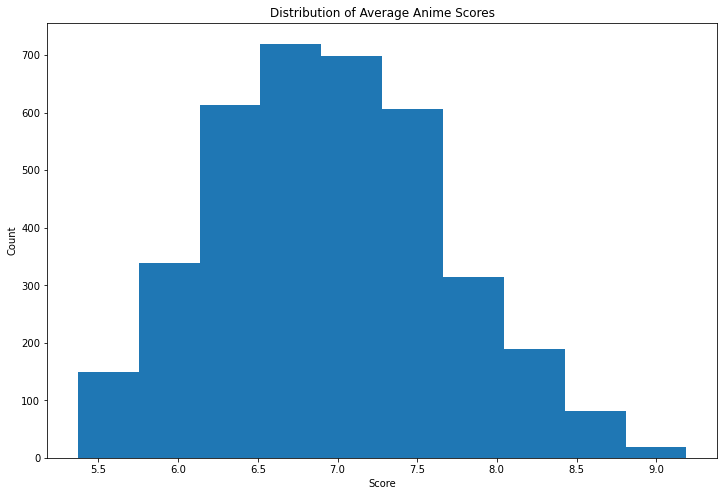

In [37]:
# Distribution of Average Anime Scores
plt.figure(figsize=(12, 8))
plt.hist(df['score'])
plt.title('Distribution of Average Anime Scores')
plt.ylabel('Count')
plt.xlabel('Score');

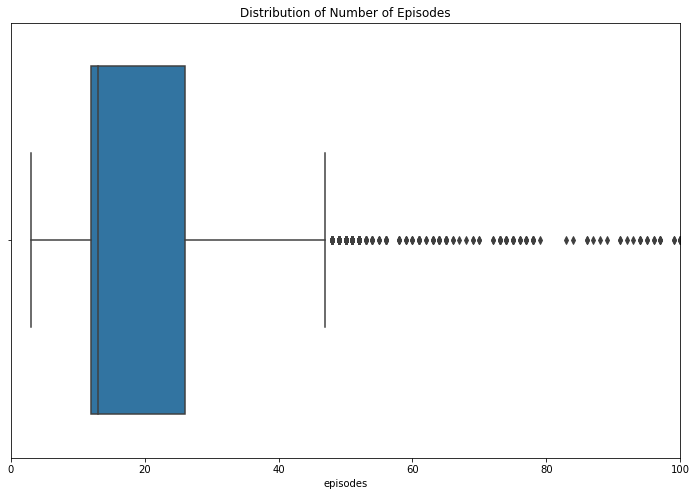

In [38]:
plt.figure(figsize=(12, 8))
plt.title('Distribution of Number of Episodes')
plt.xlim(0, 100)
sns.boxplot(data=df, x='episodes');